In [440]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-paper')

In [441]:
dfs = []
columns = []
c = 0
for filename in glob.iglob("*/progress.csv", recursive=True):
    statinfo = os.stat(filename)
    if statinfo.st_size > 0:
        df = pd.read_csv(filename)
        for column in df:
            if column not in columns:
                columns.append(column)
        dfs.append((filename[:-13], df))
        c += 1

named_dfs = []
for filename, df in dfs:
    # Humanoid-v2__timesteps_8000000__simsteps_50__trainsteps_25__noise_adaptive-param_0.2__sharing_shallow__seed_4
    dfc = df.copy()
    params = filename.split('__') 
    dfc['env'] = params[0]
    dfc['timesteps'] = int(params[1].split('_')[-1])
    dfc['seed'] = int(params[-1].split('_')[-1])
    dfc['sharing'] = params[-2].split('_')[-1]
    dfc['noise'] = params[-3].split('_')[-2]
    dfc['simsteps'] = int(params[-5].split('_')[-1])
    dfc['trainsteps'] = int(params[-4].split('_')[-1])
    named_dfs.append(dfc)
all_df = pd.concat(named_dfs)

In [442]:
len(all_df)

390816

In [443]:
all_df.noise.value_counts()

adaptive-param    337816
ou                 53000
Name: noise, dtype: int64

In [444]:
all_df.columns

Index(['env', 'eval/Q', 'eval/episodes', 'eval/return', 'eval/return_history',
       'noise', 'obs_rms_mean', 'obs_rms_std', 'param_noise_stddev',
       'reference_Q_mean', 'reference_Q_std', 'reference_action_mean',
       'reference_action_std', 'reference_actor_Q_mean',
       'reference_actor_Q_std', 'reference_perturbed_action_mean',
       'reference_perturbed_action_std', 'ret_rms_mean', 'ret_rms_std',
       'rollout/Q_mean', 'rollout/actions_mean', 'rollout/actions_std',
       'rollout/episode_steps', 'rollout/episodes', 'rollout/return',
       'rollout/return_history', 'seed', 'sharing', 'simsteps', 'timesteps',
       'total/duration', 'total/episodes', 'total/epochs', 'total/steps',
       'total/steps_per_second', 'train/loss_actor', 'train/loss_critic',
       'train/param_noise_distance', 'trainsteps'],
      dtype='object')

In [445]:
all_df['env'].value_counts()

Humanoid-v2       182812
HalfCheetah-v2    128004
Walker2d-v2        40000
Ant-v2             40000
Name: env, dtype: int64

In [457]:
mask_others = np.logical_and(all_df.trainsteps == 25, np.logical_and(all_df.noise == 'adaptive-param', all_df.env != 'Humanoid-v2'))
mask_human = np.logical_and(all_df.env == 'Humanoid-v2', all_df.timesteps >= 3000000)
other_experiment_df = all_df[mask_others]
human_experiment_df = all_df[mask_human]
human_experiment_df = human_experiment_df[human_experiment_df['total/steps'] <= 3000000]
main_experiment_df = pd.concat([other_experiment_df, human_experiment_df], axis=0)
main_experiment_df.env.value_counts()

Humanoid-v2       93885
Ant-v2            40000
Walker2d-v2       40000
HalfCheetah-v2    39000
Name: env, dtype: int64

In [458]:
main_experiment_df[['env', 'sharing', 'total/steps', 'seed', 'eval/return']].head()

,env,sharing,total/steps,seed,eval/return
0,HalfCheetah-v2,balanced,1000,3,-347.588062
1,HalfCheetah-v2,balanced,2000,3,-243.625047
2,HalfCheetah-v2,balanced,3000,3,-265.578748
3,HalfCheetah-v2,balanced,4000,3,524.521310
4,HalfCheetah-v2,balanced,5000,3,-171.245495


In [459]:
lower_perc = lambda x: np.percentile(x, 25)
upper_perc = lambda x: np.percentile(x, 75)

mean_df = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return'], data=main_experiment_df, aggfunc='mean')
median_df = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return'], data=main_experiment_df, aggfunc='median')
std_df = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return'], data=main_experiment_df, aggfunc='std')
lower_perc_df = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return'], data=main_experiment_df, aggfunc=lower_perc)
upper_perc_df = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return'], data=main_experiment_df, aggfunc=upper_perc)
max_df = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return'], data=main_experiment_df, aggfunc='max')

In [460]:
def plot_env(env_name, df, lower=None, upper=None, mean=False):
    for sharing in ['shallow', 'deep', 'none', 'balanced']:
        sel = df.loc[env_name, sharing]
        if mean:
            plt.plot(sel.index, sel['eval/return'].rolling(window=100,center=False).median(), label=sharing)
        else:
            plt.plot(sel.index, sel['eval/return'], label=sharing, lw=1, alpha=0.8)
        if lower is not None and upper is not None:
            lower_sel = lower.loc[env_name, sharing]['eval/return'].rolling(window=100,center=False).mean()
            upper_sel = upper.loc[env_name, sharing]['eval/return'].rolling(window=100,center=False).mean()
            plt.fill_between(sel.index, lower_sel, upper_sel, alpha=0.5)
    plt.title(env_name)
    plt.xlabel('steps')
    plt.ylabel('avg return')
    plt.legend()


mean False


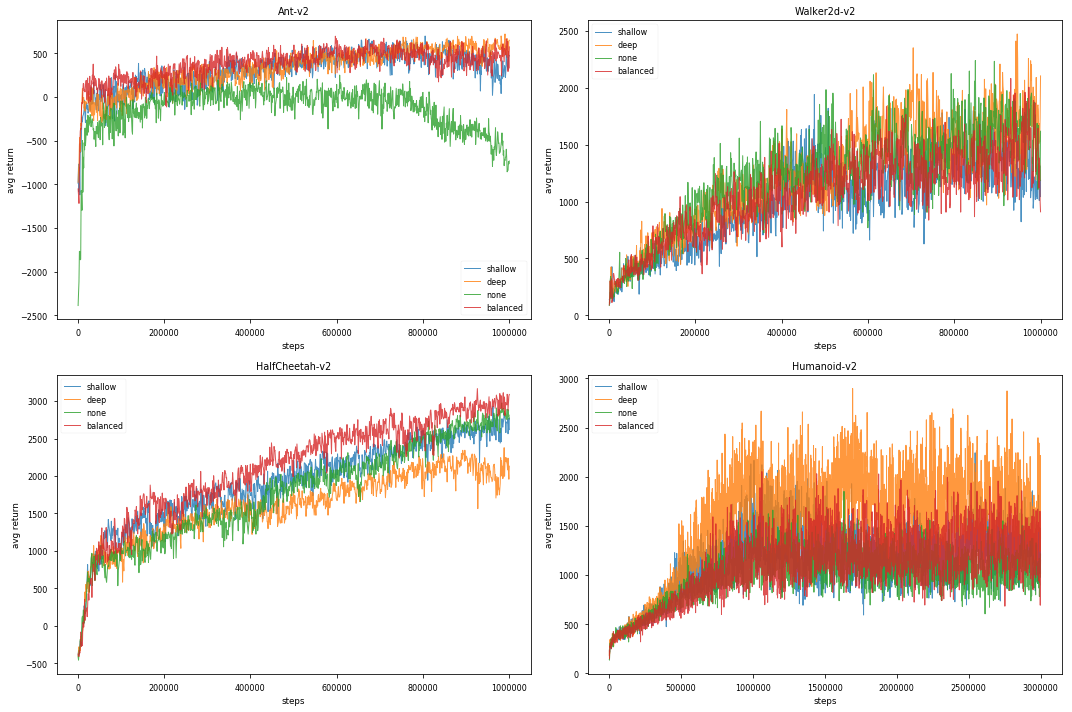

median False


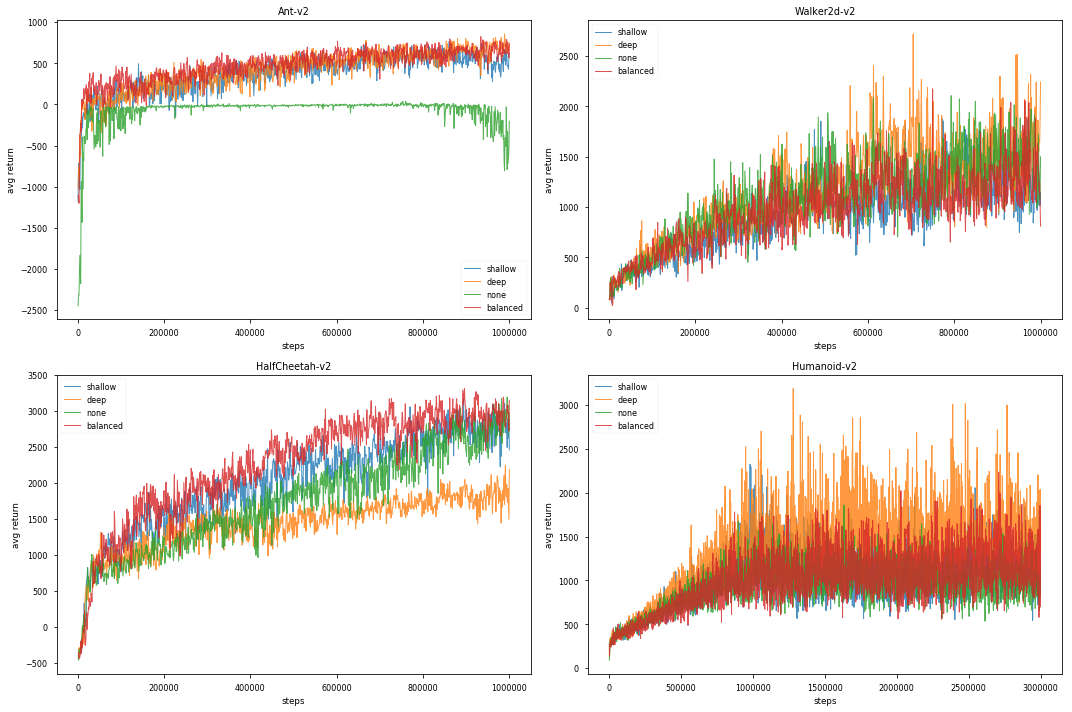

mean True


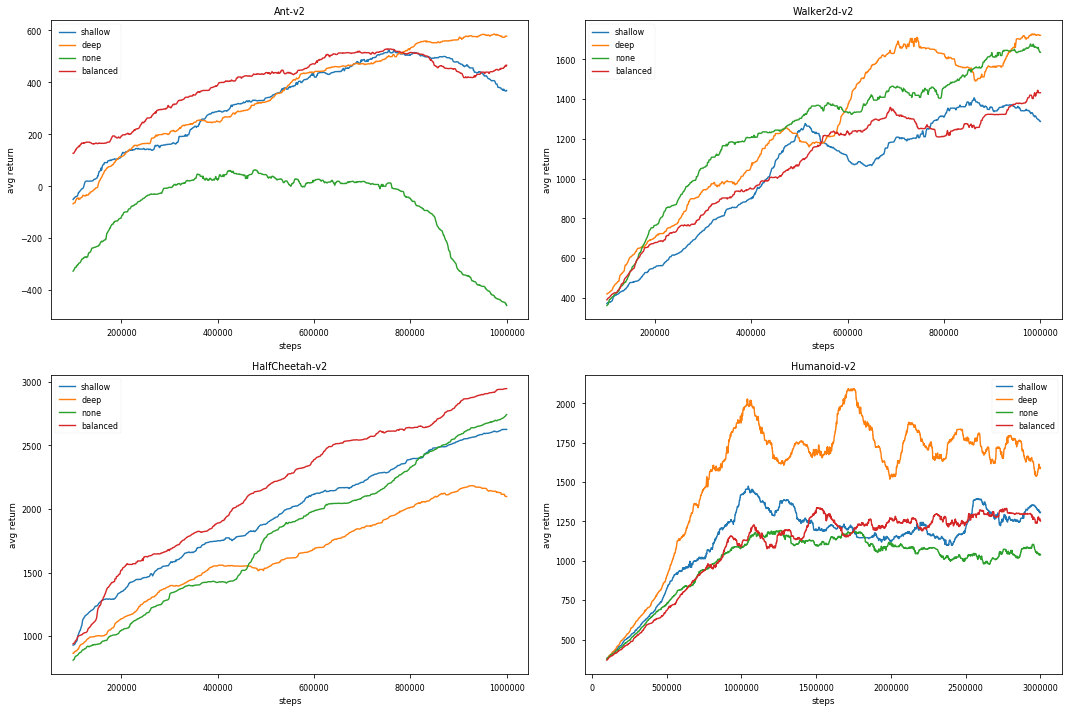

median True


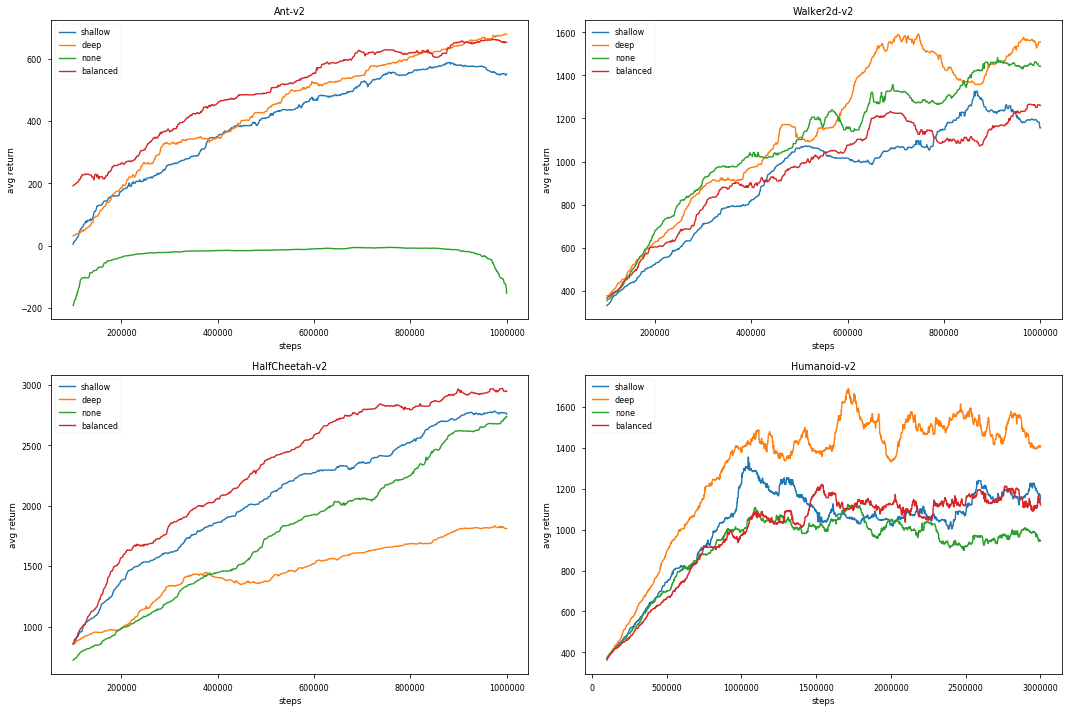

In [461]:
for use_mean in [False, True]:
    for name, df in zip(['mean', 'median'], [mean_df, median_df]):
        print(name, use_mean)
        envs = ['Ant-v2', 'Walker2d-v2', 'HalfCheetah-v2', 'Humanoid-v2']
        plt.figure(figsize=(15,10))
        for i, env in enumerate(envs):
            plt.subplot(2,2,i+1)
            plot_env(env, df, mean=use_mean)
        plt.tight_layout()
        plt.savefig('returns.pdf', bbox_inches='tight')
        plt.savefig('returns.png', bbox_inches='tight')
        plt.show()

In [578]:
colors = ['red', 'blue', 'darkorange']
cm = plt.get_cmap('inferno')
colors = cm([0,90,150])
def plot_env_paper(i, env_name, df, lower=None, upper=None, mean=False, xlabel=True, ylabel=True):
    for j, sharing in enumerate(['none', 'shallow', 'deep',]):
        sel = df.loc[env_name, sharing]
        if mean:
            plt.plot(sel.index, sel['eval/return'].rolling(window=50,center=False, min_periods=1).mean(), label=sharing, lw=1, color=colors[j])
        else:
            plt.plot(sel.index, sel['eval/return'], label=sharing, lw=1, alpha=0.8, color=colors[j])
        if lower is not None and upper is not None:
            lower_sel = lower.loc[env_name, sharing]['eval/return'].rolling(window=50,center=False, min_periods=1).mean()
            upper_sel = upper.loc[env_name, sharing]['eval/return'].rolling(window=50,center=False, min_periods=1).mean()
            plt.fill_between(sel.index, lower_sel, upper_sel, alpha=0.3, color=colors[j])
    plt.title(env_name)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if xlabel:
        plt.xlabel('simulation steps')
    if ylabel:
        plt.ylabel('avg return',labelpad=-0.3)
    if i < 3:
        plt.xlim([0,1e+6])
    else:
        plt.xlim([0, 3e+6])
#     plt.legend()

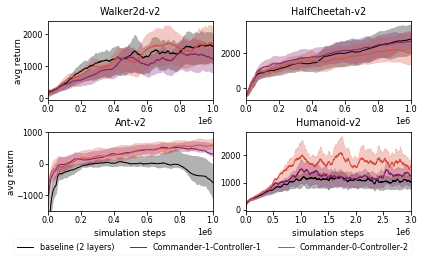

In [579]:
envs = ['Walker2d-v2', 'HalfCheetah-v2', 'Ant-v2', 'Humanoid-v2']
plt.figure(figsize=(6.5,3.5))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.4)
for i, env in enumerate(envs):
    plt.subplot(gs[i])
    plot_env_paper(i, env, mean_df, lower_perc_df, upper_perc_df, mean=True, ylabel=i % 2 ==0, xlabel=i>=2)
    plt.gca().tick_params(pad=1.3)
    if i == 2:
        plt.ylim([-1500, 1000])
plt.legend(['baseline (2 layers)', 'Commander-1-Controller-1', 'Commander-0-Controller-2'], ncol=3, bbox_to_anchor=(-1.43,-0.6), loc='lower left')
# plt.tight_layout()
plt.savefig('returns-paper.pdf', bbox_inches='tight')
plt.savefig('returns-paper.png', bbox_inches='tight')
plt.show()

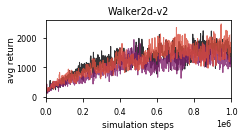

In [600]:
plt.figure(figsize=(3.5,2))
plot_env_paper(2, 'Walker2d-v2', mean_df, mean=False, ylabel=True, xlabel=True)
# plt.legend(['baseline (2 layers)', 'Commander-1-Controller-1', 'Commander-0-Controller-2'], ncol=3, bbox_to_anchor=(-0.23,-0.4), loc='lower left')
plt.tight_layout()
plt.savefig('not-smoothed.pdf', bbox_inches='tight')
plt.show()

In [464]:
median_df = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return_history'], data=main_experiment_df, aggfunc='mean')

In [465]:
res = []
for env in ['Ant-v2', 'Walker2d-v2', 'HalfCheetah-v2', 'Humanoid-v2']:
    for sharing in ['shallow', 'deep', 'none', 'balanced']:
        res.append([env, sharing, median_df.loc[env, sharing].iloc[-1][0]])

In [466]:
res_100 = pd.DataFrame(res, columns=['env', 'sharing', '100-mean'])
res_100

,env,sharing,100-mean
0,Ant-v2,shallow,356.166593
1,Ant-v2,deep,571.093078
2,Ant-v2,none,-495.180804
3,Ant-v2,balanced,456.556752
4,Walker2d-v2,shallow,1281.720958
5,Walker2d-v2,deep,1700.090799
6,Walker2d-v2,none,1627.831829
7,Walker2d-v2,balanced,1439.950574
8,HalfCheetah-v2,shallow,2628.714392
9,HalfCheetah-v2,deep,2074.415270


In [404]:
pd.pivot_table(res_100, index='sharing', columns='env', values='100-mean')

env,Ant-v2,HalfCheetah-v2,Humanoid-v2,Walker2d-v2
sharing,,,,
balanced,456.556752,2942.270981,1361.465601,1439.950574
deep,571.093078,2074.415270,1663.298764,1700.090799
none,-495.180804,2738.008697,984.184043,1627.831829
shallow,356.166593,2628.714392,1351.163166,1281.720958


In [231]:
cheetah = main_experiment_df[main_experiment_df['env'] == 'HalfCheetah-v2']

In [232]:
cheetah.head()

,env,eval/Q,eval/episodes,eval/return,eval/return_history,noise,obs_rms_mean,obs_rms_std,param_noise_stddev,reference_Q_mean,...,timesteps,total/duration,total/episodes,total/epochs,total/steps,total/steps_per_second,train/loss_actor,train/loss_critic,train/param_noise_distance,trainsteps
0,HalfCheetah-v2,-1.913492,1.0,-347.588062,-347.588062,adaptive-param,-0.037492,1.646895,0.167203,1.024731,...,1000000,13.012625,1.0,1,1000,76.848444,-1.141985,0.062001,0.288690,25
1,HalfCheetah-v2,0.978074,2.0,-243.625047,-295.606554,adaptive-param,-0.010243,1.404138,0.137031,2.841147,...,1000000,25.747282,2.0,2,2000,77.678101,-2.661911,0.095536,0.865968,25
2,HalfCheetah-v2,6.122955,3.0,-265.578748,-285.597285,adaptive-param,0.001675,1.245355,0.112303,6.176950,...,1000000,38.395617,3.0,3,3000,78.133917,-4.798973,0.115025,0.430089,25
3,HalfCheetah-v2,10.230591,4.0,524.521310,-83.067637,adaptive-param,0.005825,1.277642,0.092037,8.752797,...,1000000,50.971146,4.0,4,4000,78.475771,-7.697118,0.102341,0.584050,25
4,HalfCheetah-v2,10.195897,5.0,-171.245495,-100.703208,adaptive-param,-0.007476,1.208917,0.075428,11.321668,...,1000000,63.612083,5.0,5,5000,78.601419,-10.072289,0.156368,0.602088,25


In [233]:
set(cheetah['seed'].values)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [234]:
cheetah['seed'].value_counts()

8    4000
7    4000
6    4000
5    4000
4    4000
3    4000
2    4000
1    4000
0    4000
9    3000
Name: seed, dtype: int64

In [235]:
cheetah['sharing'].value_counts()

shallow     10000
balanced    10000
none        10000
deep         9000
Name: sharing, dtype: int64

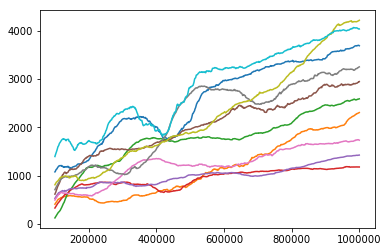

In [242]:
cheetah_none = cheetah[cheetah.sharing == 'none']
for seed in range(10):
    plt.plot(cheetah_none[cheetah_none.seed == seed]['total/steps'], cheetah_none[cheetah_none.seed == seed]['eval/return'].rolling(window=100).mean())
plt.show()

In [246]:
dfs_for_seed = [cheetah_none[cheetah_none.seed == seed] for seed in range(10)]

In [249]:
dfs_for_seed_sorted = sorted(dfs_for_seed, key=lambda df: df.iloc[-1]['eval/return_history'])

In [255]:
one = pd.concat(dfs_for_seed_sorted[:5])
two = pd.concat(dfs_for_seed_sorted[5:])

In [256]:
one_pivot = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return'], data=one, aggfunc='mean')
two_pivot = pd.pivot_table(index=['env', 'sharing', 'total/steps'], values=['eval/return'], data=two, aggfunc='mean')


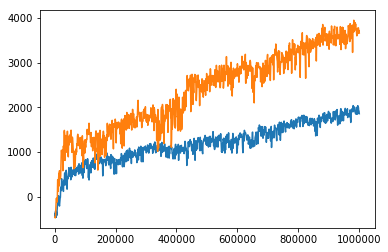

In [266]:
plt.plot(one_pivot.loc['HalfCheetah-v2', 'none'].index, one_pivot['eval/return'].values)
plt.plot(two_pivot.loc['HalfCheetah-v2', 'none'].index, two_pivot['eval/return'].values)
plt.show()

In [300]:
noise_mask = np.logical_and(np.logical_and(all_df.env == 'HalfCheetah-v2', all_df.noise == 'adaptive-param'), all_df.sharing == 'none')
noise_experiment_df = all_df[noise_mask]
noise_experiment_df.noise.value_counts() / 1000

adaptive-param    18.0
Name: noise, dtype: float64

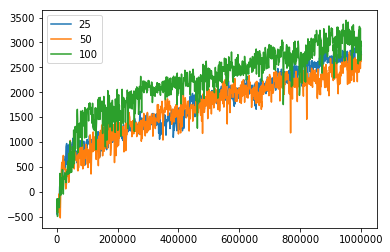

In [303]:
pivot_noise = pd.pivot_table(noise_experiment_df, index=['trainsteps', 'total/steps'], values=['eval/return'])
for noise in [25, 50, 100]:
    sel = pivot_noise.loc[noise]
    plt.plot(sel.index, sel['eval/return'], label=noise)
plt.legend()
plt.show()